# Headers

In [1]:
from __future__ import print_function

try:
    %matplotlib inline
except NameError:
    pass
import pylab
import matplotlib
import matplotlib.pyplot as plt

import json
import copy
import os
import scipy
import scipy.ndimage
import itertools
import random
import math
import numpy as np
import sys
import tensorflow as tf

from collections import namedtuple, OrderedDict, defaultdict
from io import BytesIO
from struct import pack, unpack

def info(*args, **kwargs):
    print(*args, **kwargs)

In [2]:
info("TF version:", tf.__version__)

TF version: 1.2.1


# Config

In [3]:
DIR = "model_dash/"
if not os.path.isdir(DIR):
    os.mkdir(DIR)
    
OUT_DIR = DIR
DATA_PATH = "data_ord"
LOGFILE = open(DIR + "train.log", "w")

PLOT = True
TEST = True
TENSORBOARD = True

DATA_PATHS = ["{}/feat_norm.ark".format(DATA_PATH)]
LABELS_PATHS = ["{}/index.json".format(DATA_PATH)]
TIMESTAMPS_PATHS = ["{}/alignments.json".format(DATA_PATH)]
EMBEDDINGS_PATHS = ["{}/embeddings.ark".format(DATA_PATH)]

MODE_ACOUSTIC = "acoustic"
MODE_TEXT = "text"
MODE_HYBRID = "hybrid"

#MODE = MODE_ACOUSTIC
MODE = MODE_HYBRID
#MODE = MODE_TEXT

NUM_CLASSES = 2

NUM_EPOCHES = 20

TRAIN_FRACTION = 0.8

MODEL_FILENAME = DIR + "model.chkpt"
OUTPUT_FROZEN_GRAPH = "graph"

# Load data

In [7]:
Sample = namedtuple("Sample", ["name", "features", "label", "accented_word", "text"])
TimeStamp = namedtuple("TimeStamp", ["start", "stop", "text"])

class Data(object):
    """Class for loading data and batching.
    features are of shape (time, dim)"""
    def __init__(self, datapaths, embeddingspaths, labelpaths, timestampspaths, config=dict()):
        self._config = Data.set_default_params(config)
        self._data, self._feature_ranges, self._has_accents = \
            Data._loaddata(datapaths, embeddingspaths, labelpaths, timestampspaths, self._config)
        self._numclasses = max([sample.label for sample in self._data]) + 1
        self._maxduration = max([len(sample.features) for sample in self._data])
        self._dim = self._data[0].features.shape[-1]
        for sample in self._data:
            assert sample.features.shape[-1] == self._dim
        #self._config["mean"], self._config["std"] = self.get_mean_std()
        
    def __len__(self):
        return len(self._data)
    
    def __iter__(self):
        return iter(self._data)
    
    def __getitem__(self, key):
        return self._data[key]
    
    @property
    def numclasses(self):
        return self._numclasses
    
    @property
    def dim(self):
        return self._dim
    
    @property
    def acoustic_range(self):
        return self._feature_ranges.get("acoustic", None)
    
    @property
    def embeddings_range(self):
        return self._feature_ranges.get("embeddings", None)
    
    @property
    def maxduration(self):
        return self._maxduration

    @staticmethod
    def set_default_params(config):
        new_config = {"label_map": {b"declaration": 0,
                                    b"question": 1,
                                    "general_question": 1,
                                    "open_question": 1}
                     }
        new_config.update(config)
        return new_config
    
    def split(self, fraction):
        data = self._data
        del self._data
        part1 = copy.deepcopy(self)
        part2 = copy.deepcopy(self)
        self._data = data
        random.seed(777)  # For reproducible results
        random.shuffle(data)
        nsplit = int(len(data) * fraction)
        part1._data = data[:nsplit]
        part2._data = data[nsplit:]
        return part1, part2
    
    def sort(self, keys, reverse=False):
        data = list(zip(self._data, keys))
        self._data = [t[0] for t in sorted(data, key=lambda x: x[1], reverse=reverse)]
    
    def subsample(self, start, stop):
        data = self._data
        del self._data
        result = copy.deepcopy(self)
        self._data = data
        result._data = data[start:stop]
        return result
    
    def split_pos_neg(self):
        assert self.numclasses == 2, "Multiclass is not supported"
        data = self._data
        data_pos = []
        data_neg = []
        for sample in data:
            if sample.label:
                data_pos.append(sample)
            else:
                data_neg.append(sample)
        del self._data
        pos = copy.deepcopy(self)
        neg = copy.deepcopy(self)
        self._data = data
        pos._data = data_pos
        neg._data = data_neg
        return pos, neg
    
    def append_data(self, data):
        self._data = self._data + data._data
    
    def get_mean_std(self):
        means = [np.mean(sample.features, axis=0, keepdims=True) for sample in self._data]
        mean = np.mean(means, axis=0)
        variances = [np.var(sample.features, axis=0, keepdims=True) for sample in self._data]
        var = np.mean(variances, axis=0)
        std = np.sqrt(var)
        std[std < 1e-6] = 1.0
        return mean, std
        
    def numbatches(self, batchsize):
        return int((len(self) - 1) / batchsize) + 1
    
    def iterbatches(self, batchsize):
        random.shuffle(self._data)
        for i in range(0, len(self), batchsize):
            yield self._make_batch_dict(self._data[i:i + batchsize], self._has_accents, self._config)
            
    def makedict(self):
        return self._make_batch_dict(self._data, self._has_accents, self._config)
    
    @staticmethod
    def _loaddata(datapaths, embeddingspaths, labelpaths, timestampspaths, config):
        acoustic_features = dict()
        for path in datapaths:
            acoustic_features.update(Data._loadark(path))
        word_embeddings = dict()
        for path in embeddingspaths:
            word_embeddings.update(Data._loadark(path))
        labels = dict()
        for path in labelpaths:
            labels.update(Data._loadlabels(path, config))
        timestamps = dict()
        for path in timestampspaths:
            timestamps.update(Data._loadtimestamps(path))
        for key, in labels:
            #print("labels", type(key))
            break
        timestamps_new= dict()
        for key in timestamps:
            timestamps_new[key.decode()] = timestamps[key]
            #print(key)
            
        has_accents = True
        feature_ranges = dict()
        data = []
        keys = list(acoustic_features.keys()) if acoustic_features else list(word_embeddings.keys())
        #print('labels:', labels)
        for key in keys:
            #print("key:", type(key))
            if key not in labels:
                continue
            label, accented_word, accented_text = labels[key]
            if label == config["label_map"]["general_question"] and accented_word == -1:
                info("Question {} has no accented word. Skipping".format(key))
                continue
            if accented_word is None:
                has_accents = False
            if key not in timestamps_new:
                info("No timestamps for {}. Skipping".format(key))
                continue
            ts = timestamps_new[key]
            num_words = len(ts)
            if num_words > 30:
                #print("Very long:", key)
                continue
            if accented_text is not None:
                non_sil_words = [w.text for w in ts if w.text != u"-"]
                if accented_word >= len(non_sil_words):
                    info("Recognition out of range in {}".format(key))
                    continue
                if accented_text != non_sil_words[accented_word]:
                    info("Recognition mismatch: {} != {} in {}".format(
                        accented_text.encode("utf8"),
                        non_sil_words[accented_word].encode("utf8"),
                        key))
                    continue
            words = [w.text for w in ts]
            if num_words == 0:
                # Fill features later
                data.append(Sample(key, None, label, accented_word, words))
                continue
                
            feats_issil = np.array([w.text == u"-" for w in ts], dtype=np.float32).reshape((-1, 1))
            feats_index = np.arange(num_words, dtype=np.float32).reshape((-1, 1))
            feats_duration = np.array([w.stop - w.start for w in ts], dtype=np.float32).reshape((-1, 1))
            feats_tempo = np.array([(w.stop - w.start) / float(len(w.text)) for w in ts], dtype=np.float32).reshape((-1, 1))
            all_feats = [] #feats_index, feats_issil, feats_duration, feats_tempo]
            if acoustic_features:
                feats = acoustic_features[key].T
                feature_start = sum([f.shape[1] for f in all_feats])
                feature_len = feats.shape[1]
                all_feats.append(feats)
                feature_ranges["acoustic"] = (feature_start, feature_start + feature_len)
            if word_embeddings:
                word_feats = word_embeddings[key]
                feature_start = sum([f.shape[1] for f in all_feats])
                feature_len = word_feats.shape[1]
                feats = []
                sil_feats = np.zeros(word_feats.shape[-1], dtype=np.float32)
                i = 0
                for w in ts:
                    if w.text == u"-":
                        feats.append(sil_feats)
                    else:
                        feats.append(word_feats[i])
                        i += 1
                assert i == len(word_feats) - 1  # Last embedding is for EOF, drop it
                feats = np.array(feats)
                all_feats.append(feats)
                feature_ranges["embeddings"] = (feature_start, feature_start + feature_len)
            
            #print(key, words)
            #print([f.shape for f in all_feats])
            
            try:
                data.append(Sample(key, np.hstack(all_feats), label, accented_word, words))
            except Exception:
                #print("Error appending sample", key)
                continue
            dim = data[-1].features.shape[-1]
        for i in range(len(data)):
            if data[i].features is None:
                data[i] = Sample(data[i].name, np.zeros((1, dim), dtype=np.float32),
                                 data[i].label, data[i].accented_word, data[i].text)
                
        return data, feature_ranges, has_accents
    
    @staticmethod
    def _loadmat(fp):
        fmt, _, isize1, nrows, isize2, ncols = unpack("=3sbbibi", fp.read(14))
        assert fmt == b"BFM", fmt
        assert isize1 == 4 and isize2 == 4
        buf = fp.read(4 * nrows * ncols)
        assert len(buf) == 4 * nrows * ncols
        mat = np.frombuffer(buf, dtype="f4").reshape((nrows, ncols))
        return mat

    @staticmethod
    def _loadark(fname):
        ark = dict()
        buf = open(fname, "rb").read()
        fp = BytesIO(buf)
        while fp.tell() < len(buf):
            c = fp.tell()
            uid = fp.read(buf.index(b" ", c) - c)
            _ = fp.read(2)
            ark[uid.decode()] = Data._loadmat(fp)
        return ark
    
    @staticmethod
    def _loadlabels(fname, config):
        labels = list()
        with open(fname, encoding='utf-8') as fp:
            for line in fp:
                info = json.loads(line)
                accented_word = info.get("accented_word", None)
                if accented_word is not None and accented_word > 0:
                    accented_word -= 1
                if accented_word is not None and accented_word >= 0:
                    accented_text = info["text"].lower().split()[accented_word]
                else:
                    accented_text = None
                label = config["label_map"][info["purpose"].encode("utf8")]
                if label is not None:
                    labels.append((info["ID"], (label, accented_word, accented_text)))
        return dict(labels)
    
    @staticmethod
    def _loadtimestamps(fname):
        timestamps = list()
        with open(fname, encoding='utf-8') as fp:
            for line in fp:
                toks = json.loads(line)
                words = [TimeStamp(w["start"], w["stop"], w["text"]) for w in toks["words"]]
                timestamps.append((toks["ID"].encode(), words))
        return dict(timestamps)
    
    @staticmethod
    def _make_batch_dict(data, has_accents, config):
        def pad(feature, dim):
            return np.vstack([feature,
                              np.zeros((dim - feature.shape[0], feature.shape[1]),
                                       dtype=np.float32)])
        names, features, labels, accented_words, texts = zip(*data)
        lengths = list(map(len, features))
        maxduration = np.max(lengths)
        features = map(lambda f: pad(f, maxduration), features)
        labels = np.array(labels)
        features = np.stack(features, axis=0)
        lengths = np.array(lengths)
        batch_dict = {
            "features": features,
            "labels": labels,
            "lengths": lengths,
            "names": names
        }
        if has_accents:
            accented_words = np.array(accented_words)
            batch_dict["accented_words"] = accented_words
        return batch_dict

In [8]:
def load_data(*paths, **kwargs):
    train_fraction=kwargs.get("train_fraction", TRAIN_FRACTION)
    
    paths = list(paths)
    if MODE == MODE_HYBRID:
        pass
    elif MODE == MODE_ACOUSTIC:
        paths[1] = []
    elif MODE == MODE_TEXT:
        paths[0] = []
    else:
        assert False
    
    data = Data(*paths)
    
    assert data.numclasses <= NUM_CLASSES
    data_train, data_valid_test = data.split(train_fraction)
    data_valid, data_test = data_valid_test.split(0.5)
    data_mean, data_std = data_train.get_mean_std()
    
    labels = np.array([sample.label for sample in data_valid])
    for i in range(NUM_CLASSES):
        info("Class {} prob: {}".format(i, np.sum(labels == i) / float(len(labels))))
    info("")

    info("Feature dimension:", data.dim)
    info("Max duration:", data.maxduration)
    info("")

    info("Acoustic range:", data.acoustic_range)
    info("Embeddings range:", data.embeddings_range)
    info("")

    info("Train size:", len(data_train))
    info("Valid size:", len(data_valid))
    info("Test size:", len(data_test))
    info("")
    
    return data, data_train, data_valid, data_test, data_mean, data_std

In [9]:
info("Load data")
info("")
data, data_train, data_valid, data_test, data_mean, data_std = \
    load_data(DATA_PATHS, EMBEDDINGS_PATHS, LABELS_PATHS, TIMESTAMPS_PATHS)

Load data

Class 0 prob: 0.815028901734104
Class 1 prob: 0.18497109826589594

Feature dimension: 649
Max duration: 30

Acoustic range: (0, 349)
Embeddings range: (349, 649)

Train size: 6920
Valid size: 865
Test size: 866



# Graph utils

In [7]:
class ExtractGatesWrapper(tf.nn.rnn_cell.RNNCell):
    """Output some inner tensors of RNN cell. If tensor_names is None,
    than cell output is directly passed"""
    
    def __init__(self, cell, tensor_names=None):
        super(ExtractGatesWrapper, self).__init__()
        self._cell = cell
        self._tensor_names = tensor_names
        
    def zero_state(self, *args, **kwargs):
        return self._cell.zero_state(*args, **kwargs)
    
    @property
    def state_size(self):
        return self._cell.state_size
        
    @property
    def output_size(self):
        if self._tensor_names is None:
            return self._cell.output_size
        else:
            return [self._cell.output_size] * len(self._tensor_names)
    
    @property
    def num_outputs(self):
        assert self._tensor_names is not None
        return len(self._tensor_names)
    
    @property
    def output_name(self, i):
        assert self._tensor_names is not None
        return self._tensor_names[i]
        
    def __call__(self, inputs, state, scope):
        if self._tensor_names is None:
            return self._cell(inputs, state, scope)
        
        class persistent_locals(object):
            def __init__(self, func):
                self._locals = {}
                self.func = func

            def __call__(self, *args, **kwargs):
                def tracer(frame, event, arg):
                    if event=='return':
                        self._locals = frame.f_locals.copy()

                # tracer is activated on next call, return or exception
                sys.setprofile(tracer)
                try:
                    # trace the function call
                    res = self.func(*args, **kwargs)
                finally:
                    # disable tracer and replace with old one
                    sys.setprofile(None)
                return res

            def clear_locals(self):
                self._locals = {}

            @property
            def locals(self):
                return self._locals
        
        self._cell._set_scope(scope)
        with tf.variable_scope(
            self._cell._scope, reuse=(self._cell.built or self._cell._reuse)) as scope:
            with tf.name_scope(scope.original_name_scope):
                cell_call = persistent_locals(self._cell.call)
                m, new_state = cell_call(inputs, state)
                output_tensors = [cell_call._locals[name] for name in self._tensor_names]
        return output_tensors, new_state

# Make graph

In [8]:
class Graph(tf.Graph):
    """Question intonation word-rnn graph"""
    
    def __init__(self, config=dict()):
        super(Graph, self).__init__()
        
        self._config = self.set_default_params(config)
        self._summary = None
        self._run_metadata = None
        self._run_metadata_attached = False
        
        with self.as_default():
            self._placeholders = self._make_placeholders(self._config)

            # Make graph
            self._normalized_features = self._make_preprocessor(self._placeholders["features"], self._config)
            self._normalized_features_alt = self._make_preprocessor(self._placeholders["features_alt"], self._config)
            
            self._output_logits = dict()
            self._outputs = dict()
            self._var_list = dict()
            self._losses = dict()
            self._optimizers = dict()
            self._loss_to_model = dict()
            
            self._output_logits["purpose"], self._var_list["purpose"] = self._make_model(
                self._placeholders,
                self._normalized_features, self._placeholders["lengths"],
                self._config, reuse=False)
                
            self._rnn_gates, _ = self._make_model(
                self._placeholders,
                self._normalized_features, self._placeholders["lengths"],
                self._config, reuse=True, gate_activations=True)
            
            self._output_logits["accent"], self._var_list["accent"] = self._make_gates_model(
                self._placeholders,
                self._rnn_gates, self._placeholders["lengths"],
                self._config, reuse=False)
            self._var_list["accent"].extend(self._var_list["purpose"])
            
            if self._config["pair_loss"]:
                self._output_logits["purpose_alt"], self._var_list["purpose_alt"] = self._make_model(
                    self._placeholders,
                    self._normalized_features_alt, self._placeholders["lengths_alt"],
                    self._config, reuse=True)
            
            for model_type in self._output_logits:
                self._outputs[model_type] = self._make_softmax(self._output_logits[model_type], self._config)
            
            self._losses["xent"] = self._make_loss_xent(
                self._output_logits["purpose"],
                self._placeholders["labels"],
                self._config)
            self._loss_to_model["xent"] = "purpose"
            
            self._losses["xent_accent"] = self._make_loss_xent(
                self._output_logits["accent"],
                self._expand_accented_words(self._placeholders["accented_words"], tf.shape(self._normalized_features)[1]),
                self._config)
            self._loss_to_model["xent_accent"] = "accent"

            if self._config["pair_loss"]:
                self._pair_stretch, self._losses["pair"] = self._make_loss_pair(scores_pos=self._output_logits["purpose"],
                                                                                scores_neg=self._output_logits["purpose_alt"],
                                                                                stretch=self._placeholders["pair_loss_stretch"],
                                                                                config=self._config)
                self._loss_to_model["pair"] = "purpose"

            for loss_type, var_list in self._loss_to_model.items():
                self._optimizers[loss_type] = self._make_optimizer(self._losses[loss_type],
                                                                   self._placeholders["learning_rate"],
                                                                   self._var_list[var_list],
                                                                   self._config)
            
            self._savers = dict()
            for model_type in self._outputs:
                self._savers[model_type] = self._make_saver(self._var_list[model_type], self._config)
            
            # Init interface
            self._input_tensors = [self._placeholders["features"], self._placeholders["lengths"]]
            self._output_tensor = self._outputs["purpose"]
            self._info_tensors = []
            
            # Init summaries
            
            tf.summary.scalar("learning_rate", self._placeholders["learning_rate"])
        
            self._losses_integrator_input = tf.placeholder(tf.float32, shape=(None, ), name="losses_integrator_input")
            self._losses_summaries = dict()
            for loss_type in self._losses:
                self._losses_summaries[loss_type] = \
                    self._make_loss_summary(self._losses_integrator_input, loss_type, self._config)
                    
            if self._config["pair_loss"]:
                tf.summary.scalar("pair_stretch", self._pair_stretch)
            
            if config.get("summary_path", None) is not None:
                self._merged_summary_op = tf.summary.merge_all()
            else:
                self._merged_summary_op = None
        
    @staticmethod
    def set_default_params(config=dict()):
        new_config = {"numclasses": NUM_CLASSES,
                      "featdim": 553,
                      "select_features": None,  # list of indices of features to extract
                      "global_mean": None,
                      "global_std": None,
                      "normalization": None,
                      "input_projection_size": 32,
                      "bottleneck_size": 16,
                      "gates_fc_layer_size": 32,
                      "rnn_num_layers": 1,
                      "rnn_num_units": 64,
                      "leaky_relu_alpha": 0.01,
                      "pair_loss": False,
                      "pair_loss_stretch": 1.0,
                      "pair_loss_sq_weight": 0.1,
                      "optimizer": tf.train.AdamOptimizer,
                      "gradient_clipping": 5.0,
                      "fc_input_dropout": True,
                      "make_bottleneck": True,
                      "summary_path": None}
        for k in config:
            assert k in new_config, "Unknown option {}".format(k)
        new_config.update(config)
        return new_config
    
    @staticmethod
    def set_default_train_params(config=dict()):
        new_config = {
            "batch_size": 32,
            "learning_rate": 1e-3,
            "rnn_input_keep_prob": 1.0,
            "rnn_output_keep_prob": 1.0,
            "rnn_state_keep_prob": 1.0,
            "pair_sort_margin": True,
            "pair_max_batches": 5000
        }
        new_config.update(config)
        return new_config
    
    def initialize(self):
        if self._merged_summary_op is not None:
            self._summary_writer = {
                "train": tf.summary.FileWriter(config["summary_path"] + "train", graph=self),
                "valid": tf.summary.FileWriter(config["summary_path"] + "valid", graph=self)
            }
        session = tf.get_default_session()
        self._run_metadata = tf.RunMetadata()
        session.run([tf.global_variables_initializer()])
        
    def _make_epoch(self, data, loss, optimizer, config=dict(), train=True):
        pair = ("pair" in self._losses and loss == self._losses["pair"])
        if pair:
            info("Eval scores")
            data_pos, data_neg = data.split_pos_neg()
            if config["pair_sort_margin"] and train:
                info("Sort samples for pair loss")
                scores_pos = self.predict(data_pos, model="purpose", logits=True)[:, 1]
                scores_neg = self.predict(data_neg, model="purpose", logits=True)[:, 0]
                data_pos.sort(scores_pos)
                data_neg.sort(scores_neg)
        config = self.set_default_train_params(config)
        mode = "Train" if train else "Valid"
        batch_size = config["batch_size"]
        if pair:
            batches_pos = list(data_pos.iterbatches(batch_size))[:-1]
            batches_neg = list(data_neg.iterbatches(batch_size))[:-1]
            max_batches = int(np.sqrt(config["pair_max_batches"]))
            batches_pos = batches_pos[:max_batches]
            batches_neg = batches_neg[:max_batches]
            num_batches = len(batches_pos) * len(batches_neg)
            batches = itertools.product(batches_pos, batches_neg)
        else:
            num_batches = data.numbatches(batch_size)
            batches = data.iterbatches(batch_size)
        losses = []
        feed_defaults = {k: v for k, v in config.items()
                         if k in ["learning_rate", "rnn_input_keep_prob", "rnn_output_keep_prob", "rnn_state_keep_prob"]}
        feed_dict = dict()
        for name, value in feed_defaults.items():
            feed_dict[self._placeholders[name]] = config[name]
        for i, batch in enumerate(batches):
            if i >= num_batches:
                break
            if pair:
                feed_dict[self._placeholders["features"]] = batch[0]["features"]
                feed_dict[self._placeholders["lengths"]] = batch[0]["lengths"]
                feed_dict[self._placeholders["features_alt"]] = batch[1]["features"]
                feed_dict[self._placeholders["lengths_alt"]] = batch[1]["lengths"]
            else:
                for name in ["features", "labels", "lengths", "accented_words"]:
                    if name in batch:
                        feed_dict[self._placeholders[name]] = batch[name]
            if train:
                _, step_loss = self._run([optimizer, loss], feed_dict)
            else:
                step_loss = self._run([loss], feed_dict)[0]
            losses.append(step_loss)
            info("{} batch loss ({} / {}): {}\r".format(mode, i + 1, num_batches, step_loss), end="")
        info("")
        return losses
    
    def make_epoch(self, i, data, config=dict(), train=True, loss_type="xent", info_mode=None):
        """Make one epoch of training or just compute loss
        info_mode -- if "train" or "valid" then dump loss into TB summary"""
        assert info_mode in {None, "train", "valid"}
        assert loss_type in self._losses, "loss {} is not known".format(loss_type)
        losses = self._make_epoch(data, self._losses[loss_type], self._optimizers[loss_type], config, train)
        if info_mode is not None and self._merged_summary_op is not None:
            kwargs = dict()
            if self._run_metadata is not None:
                kwargs["run_metadata"] = self._run_metadata
            feed_dict = {self._losses_integrator_input: losses}
            for name in ["learning_rate", "rnn_input_keep_prob", "rnn_output_keep_prob", "rnn_state_keep_prob"]:
                feed_dict[self._placeholders[name]] = config[name]
            self._summary = self._run([self._merged_summary_op],
                                       feed_dict=feed_dict,
                                       **kwargs)[0]
            if info_mode is not None:
                self.dump_summary(i, info_mode)
        mean_loss = np.mean(losses)
        return mean_loss
    
    def predict(self, data, logits=False, model="purpose"):
        batch = data.makedict()
        feed_dict = {self._placeholders[name]: batch[name]
                     for name in ["features", "labels", "lengths", "accented_words"] if name in batch}
        outputs = self._output_logits if logits else self._outputs
        return self._run([outputs[model]], feed_dict)[0]
    
    def dump(self, path, model="purpose"):
        """Dump checkpoint"""
        session = tf.get_default_session()
        self._savers[model].save(session, path)
    
    def load(self, path, model="purpose"):
        """Load checkpoint"""
        session = tf.get_default_session()
        self._savers[model].restore(session, path)
        
    def dump_summary(self, i, info_mode):
        """Dump Tensorboard summary"""
        if self._summary is None:
            return
        assert self._summary_writer is not None
        info("Dump summary", info_mode)
        if not self._run_metadata_attached:
            self._summary_writer["train"].add_run_metadata(self._run_metadata, "graph")
            self._summary_writer["valid"].add_run_metadata(self._run_metadata, "graph")
            self._run_metadata_attached = True
        self._summary_writer[info_mode].add_summary(self._summary, i)
        self._summary_writer[info_mode].flush()
        info("Done")
    
    def export(self, path):
        """Export frozen graph for an external usage"""
        graph_def = self.as_graph_def()
        ops = self._input_tensors + [self._output_tensor] + self._info_tensors
        graph_def = tf.graph_util.convert_variables_to_constants(session, graph_def,
                                                                 [t.op.name for t in ops])
        tf.train.write_graph(graph_def, DIR, path, as_text=False)
        info("Exported to", path)
        info("Input tensors:", self._input_tensors)
        info("Output tensor:", self._output_tensor)
        info("Info tensors:", self._info_tensors)
        
    @staticmethod
    def _make_placeholders(config):
        """Alternative feature stream is used for AUC optimization,
        when positive samples assigned to features and negative to features_alt"""
        return {
            "features": tf.placeholder(tf.float32, shape=(None, None, config["featdim"]), name="features"), # batch x time x dim
            "features_alt": tf.placeholder(tf.float32, shape=(None, None, config["featdim"]), name="features_alt"), # batch x time x dim
            "lengths": tf.placeholder(tf.int32, shape=(None), name="lengths"), # batch
            "lengths_alt": tf.placeholder(tf.int32, shape=(None), name="lengths_alt"), # batch
            "labels": tf.placeholder(tf.int32, shape=(None,), name="labels"),  # batch
            "accented_words": tf.placeholder(tf.int32, shape=(None,), name="accented_words"),  # batch
            "learning_rate": tf.placeholder(tf.float32, shape=(), name="learning_rate"),
            "rnn_input_keep_prob": tf.placeholder_with_default(tf.constant(1.0), tuple(), name="rnn_input_keep_prob"), # Dropout
            "rnn_output_keep_prob": tf.placeholder_with_default(tf.constant(1.0), tuple(), name="rnn_output_keep_prob"), # Dropout
            "rnn_state_keep_prob": tf.placeholder_with_default(tf.constant(1.0), tuple(), name="rnn_state_keep_prob"), # Dropout
            "fc_input_keep_prob": tf.placeholder_with_default(tf.constant(1.0), tuple(), name="fc_input_keep_prob"), # Dropout
            "pair_loss_stretch": tf.placeholder_with_default(tf.constant(config["pair_loss_stretch"], dtype=tf.float32), tuple(), name="pair_loss_stretch")
        }
    
    @staticmethod
    def _make_preprocessor(features, config):
        # Global normalization
        mean, std = config["global_mean"], config["global_std"]
        assert mean is not None
        assert std is not None
        features = tf.subtract(features, tf.constant(mean, name="global_mean"))
        features = tf.divide(features, tf.constant(std, name="global_std"))
        
        # Per sample normalization
        normalization = config["normalization"]
        if normalization:
            mean, var = tf.nn.moments(features, axes=[1], keep_dims=True)
            for name in normalization.split(","):
                if name == "mean":
                    features = tf.subtract(features, mean)
                elif name == "var":
                    std = tf.sqrt(var)
                    features = tf.divide(features, std)
                else:
                    assert False
        
        # Feature selection
        if config["select_features"] is not None:
            dim = features.get_shape().as_list()[-1]
            info("Select {} features out of {}".format(len(config["select_features"]), dim))
            projection = tf.constant(np.identity(dim, dtype=np.float32)[:, config["select_features"]])
            features = Graph._batch_matmul(features, projection)
            assert features.get_shape().as_list()[-1] == len(config["select_features"])
        return features
    
    @staticmethod
    def _make_model(placeholders, features, lengths, config, reuse=None, gate_activations=False):
        num_layers = config["rnn_num_layers"]
        gates_names = None
        if gate_activations:
            reuse = True
            num_layers = 1  # We need activations only for the first layer
            gates_names = ["i", "o", "f"]

        with tf.variable_scope("rnn", reuse=reuse):
            with tf.variable_scope("input_projection", reuse=reuse):
                features = Graph._make_projection(features, config["input_projection_size"], config)
            cells = []
            for i in range(num_layers):
                input_dim = features.get_shape()[-1] if i == 0 else config["rnn_num_units"]
                with tf.variable_scope("rnn_cell{}".format(i), reuse=reuse):
                    cell = Graph._make_rnn_cell(placeholders, input_dim, reuse, config, gates_names=gates_names)
                    cells.append(cell)
            cell = tf.nn.rnn_cell.MultiRNNCell(cells)
            layer_output, layer_state = tf.nn.dynamic_rnn(cell=cell,
                                                          inputs=features, 
                                                          sequence_length=lengths,
                                                          dtype=tf.float32,
                                                          time_major=False,
                                                          swap_memory=True)
            if gate_activations:
                variables =  tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="rnn")
                return tf.identity(layer_output, name="gates"), variables
            
            # layer_output: batch x time x dim
            batch_range = tf.range(tf.shape(layer_output)[0])
            indices = tf.stack([batch_range, lengths - 1], axis=1)
            final_outputs = tf.gather_nd(layer_output, indices)
            
            if config["make_bottleneck"]:
                with tf.variable_scope("bottleneck", reuse=reuse):
                    final_outputs = Graph._make_fully_connected(placeholders, final_outputs, config["bottleneck_size"], config)
            
            with tf.variable_scope("output_projection", reuse=reuse):
                output_tensor = Graph._make_projection(final_outputs, config["numclasses"], config)
        variables =  tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="rnn")
        return tf.identity(output_tensor, name="logits"), variables
    
    @staticmethod
    def _make_gates_model(placeholders, gates_activations, lengths, config, reuse=None):
        with tf.variable_scope("gates_model", reuse=reuse):
            gates_activations = gates_activations[0]  # input gate
            layer_output = Graph._make_fully_connected(placeholders, gates_activations, config["gates_fc_layer_size"], config)
            with tf.variable_scope("projection", reuse=reuse):
                output_tensor = Graph._make_projection(layer_output, 2, config)
        variables =  tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="gates_model")
        return output_tensor, variables
    
    @staticmethod
    def _expand_accented_words(accented_words, length):
        return tf.one_hot(accented_words, depth=length, dtype=tf.int32)
    
    @staticmethod
    def _make_projection(input_tensor, num_proj, config):
        projection = tf.get_variable("projection_matrix",
                                     (input_tensor.get_shape()[-1], num_proj),
                                     tf.float32,
                                     tf.contrib.layers.xavier_initializer())
        return Graph._batch_matmul(input_tensor, projection)
    
    @staticmethod
    def _batch_matmul(a, b):
        num_proj = b.get_shape().as_list()[-1]
        input_shape = tf.shape(a)
        input_flat = tf.reshape(a, [-1, a.get_shape().as_list()[-1]])
        output_flat = tf.matmul(input_flat, b)
        output_shape = tf.concat([input_shape[:-1], tf.constant(num_proj, shape=[1])], 0)
        return tf.reshape(output_flat, output_shape)
    
    @staticmethod
    def _make_rnn_cell(placeholders, input_dim, reuse, config, gates_names=None):
        cell = tf.nn.rnn_cell.LSTMCell(num_units=config["rnn_num_units"], state_is_tuple=True, reuse=reuse)
        cell = ExtractGatesWrapper(cell, gates_names)
        cell = tf.nn.rnn_cell.DropoutWrapper(cell,
                                             input_keep_prob=placeholders["rnn_input_keep_prob"],
                                             output_keep_prob=placeholders["rnn_output_keep_prob"],
                                             state_keep_prob=placeholders["rnn_state_keep_prob"],
                                             variational_recurrent=True,
                                             input_size=input_dim,
                                             dtype=tf.float32)
        return cell
    
    @staticmethod
    def _make_rnn_cell_gates(placeholders, input_dim, reuse, config):
        cell = LSTMCell(num_units=config["rnn_num_units"], state_is_tuple=True, reuse=reuse)
        cell = tf.nn.rnn_cell.DropoutWrapper(cell,
                                             input_keep_prob=placeholders["rnn_input_keep_prob"],
                                             output_keep_prob=placeholders["rnn_output_keep_prob"],
                                             state_keep_prob=placeholders["rnn_state_keep_prob"],
                                             variational_recurrent=True,
                                             input_size=input_dim,
                                             dtype=tf.float32)
        return cell
    
    @staticmethod
    def _make_convolution(placeholders, input_tensor, dims, config):
        prev_size = input_tensor.get_shape().as_list()[-1]
        kernel = (dims[1], dims[2], prev_size, dims[0])
        kernel_tensor = tf.get_variable("weights", 
                                        dtype=tf.float32,
                                        initializer=tf.truncated_normal(kernel, dtype=tf.float32, stddev=1e-1))
        conv = tf.nn.conv2d(input_tensor, kernel_tensor, [1, 1, 1, 1], padding="VALID")
        biases = tf.get_variable("biases",
                                 dtype=tf.float32,
                                 initializer=tf.constant(1.0, shape=[kernel[-1]], dtype=tf.float32))
        output_tensor = tf.nn.bias_add(conv, biases)
        return output_tensor

    @staticmethod
    def _make_pooling(placeholders, input_tensor, dims, config):
        kernel = (1, dims[0], dims[1], 1)
        output_tensor = tf.nn.max_pool(input_tensor,
                                       ksize=kernel,
                                       strides=kernel,
                                       padding="VALID",
                                       name="pool")
        return output_tensor

    @staticmethod
    def _make_fully_connected(placeholders, input_tensor, num_bins, config):
        if config["fc_input_dropout"]:
            input_tensor = tf.nn.dropout(input_tensor, placeholders["fc_input_keep_prob"])
        input_shape = tf.shape(input_tensor)
        input_dim = input_tensor.get_shape()[-1].value
        output_shape = tf.stack([input_shape[i] for i in range(len(input_tensor.get_shape()) - 1)] + [num_bins])
        weights = tf.get_variable("weights",
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal([input_dim, num_bins],
                                                                  dtype=tf.float32,
                                                                  stddev=1e-1))
        biases = tf.get_variable("biases",
                                 dtype=tf.float32,
                                 initializer=tf.constant(1.0, shape=[num_bins], dtype=tf.float32))
        
        input_flat = tf.reshape(input_tensor, [-1, input_dim])
        output_flat = tf.nn.bias_add(tf.matmul(input_flat, weights), biases)
        return tf.reshape(output_flat, output_shape)
    
    @staticmethod
    def _make_leaky_relu(placeholders, input_tensor, dims, config):
        alpha = config["leaky_relu_alpha"]
        return tf.maximum(alpha * input_tensor, input_tensor)
    
    @staticmethod
    def _make_sigmoid(placeholders, input_tensor, dims, config):
        return tf.sigmoid(input_tensor)
    
    @staticmethod
    def _make_softmax(input_tensor, config):
        return tf.nn.softmax(input_tensor)
    
    @staticmethod
    def _make_loss_xent(logits, labels, config):
        loss_xent = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))
        loss_shift = tf.square(tf.reduce_mean(logits))
        return loss_xent + loss_shift
    
    @staticmethod
    def _make_loss_mse(outputs, labels, config):
        labels = tf.one_hot(labels, config["numclasses"])
        return tf.reduce_mean(tf.square(outputs - labels))

    @staticmethod
    def _make_loss_pair(scores_pos, scores_neg, stretch, config):
        """ROC AUC optimization"""
        assert scores_pos.get_shape()[-1] == 2, "Multiclass is not implemented"
        scores_pos = scores_pos[:, 1]
        scores_neg = scores_neg[:, 1]
        losses_auc = tf.sigmoid((scores_neg - scores_pos) / stretch)
        losses_scale = tf.square(scores_neg) + tf.square(scores_pos)
        scale_weight = tf.constant(config["pair_loss_sq_weight"])
        return stretch, tf.reduce_mean(losses_auc + scale_weight * losses_scale)
    
    @staticmethod
    def _make_loss_summary(losses, suffix, config):
        with tf.name_scope("summary"):
            mean_loss = tf.reduce_mean(losses)
            tf.summary.scalar("loss_" + suffix, mean_loss)
        return mean_loss
    
    @staticmethod
    def _make_optimizer(loss, learning_rate, var_list, config):
        optimizer = config["optimizer"](learning_rate=learning_rate)
        gradients, v = zip(*optimizer.compute_gradients(loss, var_list=var_list))
        info("Optimize:", [var.name for var in v])
        gradients, _ = tf.clip_by_global_norm(gradients, config["gradient_clipping"])
        return optimizer.apply_gradients(zip(gradients, v))
    
    @staticmethod
    def _make_saver(var_list, config):
        return tf.train.Saver(max_to_keep=5, var_list=var_list)
    
    def _run(self, tensors, feed_dict=dict(), **kwargs):
        assert isinstance(tensors, list) or isinstance(tensors, tuple)
        session = tf.get_default_session()
        result = session.run(tensors, feed_dict=feed_dict, **kwargs)
        return result

In [9]:
config = {
    "summary_path": DIR,
    "featdim": data.dim,
    "select_features": None,
    "global_mean": data_mean,
    "global_std": data_std,
    "pair_loss": True
}
graph = Graph(config=config)

Optimize: ['rnn/input_projection/projection_matrix:0', 'rnn/rnn/multi_rnn_cell/cell_0/lstm_cell/kernel:0', 'rnn/rnn/multi_rnn_cell/cell_0/lstm_cell/bias:0', 'rnn/bottleneck/weights:0', 'rnn/bottleneck/biases:0', 'rnn/output_projection/projection_matrix:0']
Optimize: ['gates_model/weights:0', 'gates_model/biases:0', 'gates_model/projection/projection_matrix:0', 'rnn/input_projection/projection_matrix:0', 'rnn/rnn/multi_rnn_cell/cell_0/lstm_cell/kernel:0', 'rnn/rnn/multi_rnn_cell/cell_0/lstm_cell/bias:0', 'rnn/bottleneck/weights:0', 'rnn/bottleneck/biases:0', 'rnn/output_projection/projection_matrix:0']
Optimize: ['rnn/input_projection/projection_matrix:0', 'rnn/rnn/multi_rnn_cell/cell_0/lstm_cell/kernel:0', 'rnn/rnn/multi_rnn_cell/cell_0/lstm_cell/bias:0', 'rnn/bottleneck/weights:0', 'rnn/bottleneck/biases:0', 'rnn/output_projection/projection_matrix:0']


In [10]:
def get_roc_point(scores_pos, scores_neg, th):
    tp = np.mean(scores_pos > th)
    tn = np.mean(scores_neg < th)
    fp = 1 - tn
    return (th, tp, fp)


def get_roc(scores, labels, th_range=(-1.0, 2.0)):
    labels = np.array(labels)
    scores_pos = scores[labels == 1]
    scores_neg = scores[labels == 0]
    roc = []
    n = [0, 0]
    for score, label in sorted(itertools.chain(
        [(s, 0) for s in scores_neg],
        [(s, 1) for s in scores_pos]), key=lambda x: -x[0]):
        n[label] += 1
        tp = n[1] / float(len(scores_pos))
        fp = n[0] / float(len(scores_neg))
        roc.append((score, tp, fp))
    return roc


def get_auc(roc):
    roc = list(sorted(roc, key=lambda x: x[2]))
    ths, tps, fps = zip(*roc)
    return np.trapz(tps, fps)


def plot_roc(roc, positive_rate=None):
    ths, tps, fps = zip(*roc)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    ax.plot(fps, tps)
    ax.plot([0, 1], [0, 1], "k--", alpha=.5)
    ax.plot([1, 0], [0, 1], "k--", alpha=.5)
    if positive_rate is not None:
        x = positive_rate / (1.0 - positive_rate)
        ax.plot([0, x], [0, 1], "-", color="r", alpha=.5)
    ax.set_xlabel("False positive")
    ax.set_ylabel("True positive")
    plt.show()
    
    
def split_word_scores(all_scores, data):
    assert len(all_scores) == len(data)
    scores = []
    labels = []
    for sample, score in zip(data, all_scores):
        for i in range(sample.features.shape[0]):
            scores.append(score[i])
            labels.append(int(i == sample.accented_word))
    return np.array(scores), np.array(labels)
    

def eval_graph(graph, data, model="purpose"):
    scores = graph.predict(data, model=model)
    if model == "accent":
        scores, labels = split_word_scores(scores, data)
    else:
        labels = np.array([sample.label for sample in data])
    true_scores = np.concatenate([scores[labels == cls, cls] for cls in range(NUM_CLASSES)])
    false_scores = np.concatenate([scores[labels != cls, cls] for cls in range(NUM_CLASSES)])
    cross_entropy = -np.mean(np.log2(np.concatenate([true_scores, 1 - false_scores])))
    mse = np.mean(np.square(1 - true_scores))
    answers = np.argmax(scores, axis=1)
    accuracy = np.mean(answers == labels)
    info("Accuracy:", accuracy)
    info("CrossEntropy:", cross_entropy)
    info("MSE:", mse)
    if NUM_CLASSES == 2:
        roc = get_roc(scores[:, 1], labels)
        auc = get_auc(roc)
        info("AUC:", auc)
        return auc
    else:
        return cross_entropy

            
def train(graph, train_data, test_data, config=dict(), restore=None,
          drop_factor=0.1, max_tries=3, max_drops=3, loss_type=None, model=None):
    config = graph.set_default_train_params(config)
    epoch = 1
    num_tries = 0
    num_drops = 0
    best_loss = None
    test_loss = None
    with tf.Session(graph=graph) as session:
        if restore:
            info("Load model")
            graph.initialize()
            graph.load(MODEL_FILENAME, model=restore)
            # TODO: turn on DROPOUT during evaluation
            best_loss = graph.make_epoch(0, train_data, config=config, train=False,
                                         loss_type=loss_type, info_mode="train")
            info("Init loss:", best_loss)
            graph.dump(MODEL_FILENAME, model=model)
        else:
            info("Initialize model")
            graph.initialize()
            graph.dump(MODEL_FILENAME, model=model)
        while num_drops < max_drops:
            info("Epoch:", epoch)
            epoch += 1
            info("TEST:")
            eval_graph(graph, test_data, model=model)
            test_loss = graph.make_epoch(epoch, test_data, config=config, train=False, loss_type=loss_type,
                                         info_mode="valid")
            info("Test loss:", test_loss)
            info("TRAIN:")
            info("Learning rate:", config["learning_rate"])
            loss = graph.make_epoch(epoch, train_data, config=config, loss_type=loss_type,
                                    info_mode="train")
            info("Train loss:", loss)
            if best_loss is None or loss < best_loss:
                best_loss = loss
                info("Dump model", MODEL_FILENAME)
                graph.dump(MODEL_FILENAME, model=model)
            else:
                info("Revert")
                graph.load(MODEL_FILENAME, model=model)
                num_tries += 1
                if num_tries >= max_tries:
                    config["learning_rate"] *= drop_factor
                    num_tries = 0
                    num_drops += 1
        info("EVAL TRAIN")
        eval_graph(graph, train_data, model=model)
        train_loss = graph.make_epoch(epoch, train_data, config=config, train=False, loss_type=loss_type,
                                      info_mode="valid")

        info("EVAL TEST")
        eval_graph(graph, test_data, model=model)
        test_loss = graph.make_epoch(epoch, test_data, config=config, train=False, loss_type=loss_type,
                                     info_mode="valid")
        info("Final train loss:", train_loss)
        info("Final test loss:", test_loss)

## Train question prediction

In [11]:
# XENT TRAIN

train_config = {"learning_rate": 1e-3,
                "batch_size": 64,
                "pair_loss_stretch": 0.5,
                "rnn_input_keep_prob": 0.5,
                "rnn_state_keep_prob": 0.5}
train(graph, data_train, data_valid, train_config, restore=None, loss_type="xent", model="purpose", max_drops=2)

Initialize model
Epoch: 1
TEST:
Accuracy: 0.208092485549
CrossEntropy: 1.38744
MSE: 0.375504
AUC: 0.515514184397
Valid batch loss (14 / 14): 3.2513599395751953
Dump summary valid
Done
Test loss: 3.26923
TRAIN:
Learning rate: 0.001
Train batch loss (109 / 109): 0.48056766390800476
Dump summary train
Done
Train loss: 0.904367
Dump model model_dash/model.chkpt
Epoch: 2
TEST:
Accuracy: 0.815028901734
CrossEntropy: 0.638541
MSE: 0.13958
AUC: 0.713820921986
Valid batch loss (14 / 14): 0.51926523447036746
Dump summary valid
Done
Test loss: 0.456566
TRAIN:
Learning rate: 0.001
Train batch loss (109 / 109): 0.41259878873825073
Dump summary train
Done
Train loss: 0.447373
Dump model model_dash/model.chkpt
Epoch: 3
TEST:
Accuracy: 0.846242774566
CrossEntropy: 0.539629
MSE: 0.113269
AUC: 0.80725177305
Valid batch loss (14 / 14): 0.44142907857894916
Dump summary valid
Done
Test loss: 0.416861
TRAIN:
Learning rate: 0.001
Train batch loss (109 / 109): 0.16206820309162147
Dump summary train
Done
Train

Valid batch loss (14 / 14): 0.34099802374839784
Dump summary valid
Done
Test loss: 0.332639
TRAIN:
Learning rate: 0.0001
Train batch loss (109 / 109): 0.12238667160272598
Dump summary train
Done
Train loss: 0.304144
Dump model model_dash/model.chkpt
Epoch: 25
TEST:
Accuracy: 0.872832369942
CrossEntropy: 0.482091
MSE: 0.0998336
AUC: 0.866994680851
Valid batch loss (14 / 14): 0.45571476221084595
Dump summary valid
Done
Test loss: 0.340725
TRAIN:
Learning rate: 0.0001
Train batch loss (109 / 109): 0.79413324594497687
Dump summary train
Done
Train loss: 0.30156
Dump model model_dash/model.chkpt
Epoch: 26
TEST:
Accuracy: 0.870520231214
CrossEntropy: 0.479362
MSE: 0.0988485
AUC: 0.86649822695
Valid batch loss (14 / 14): 0.33774080872535706
Dump summary valid
Done
Test loss: 0.348291
TRAIN:
Learning rate: 0.0001
Train batch loss (109 / 109): 0.19844545423984528
Dump summary train
Done
Train loss: 0.306267
Revert
INFO:tensorflow:Restoring parameters from model_dash/model.chkpt
Epoch: 27
TEST:


In [12]:
# AUC TRAIN
train_config = {"learning_rate": 1e-4,
                "batch_size": 64,
                "pair_loss_stretch": 0.2,
                "rnn_input_keep_prob": 0.5,
                "rnn_state_keep_prob": 0.5}
train(graph, data_train, data_valid, train_config, restore="purpose", loss_type="pair", model="purpose", max_drops=2)

Load model
INFO:tensorflow:Restoring parameters from model_dash/model.chkpt
Eval scores
Valid batch loss (1330 / 1330): 0.49086010456085205
Dump summary train
Done
Init loss: 0.575503
Epoch: 1
TEST:
Accuracy: 0.870520231214
CrossEntropy: 0.479362
MSE: 0.0988485
AUC: 0.86649822695
Eval scores
Valid batch loss (22 / 22): 0.5901160240173345
Dump summary valid
Done
Test loss: 0.600389
TRAIN:
Learning rate: 0.0001
Eval scores
Sort samples for pair loss
Train batch loss (1330 / 1330): 0.40227848291397095
Dump summary train
Done
Train loss: 0.406848
Dump model model_dash/model.chkpt
Epoch: 2
TEST:
Accuracy: 0.828901734104
CrossEntropy: 0.567877
MSE: 0.123474
AUC: 0.866241134752
Eval scores
Valid batch loss (22 / 22): 0.41793453693389894
Dump summary valid
Done
Test loss: 0.407786
TRAIN:
Learning rate: 0.0001
Eval scores
Sort samples for pair loss
Train batch loss (1330 / 1330): 0.38040941953659067
Dump summary train
Done
Train loss: 0.393876
Dump model model_dash/model.chkpt
Epoch: 3
TEST:
Ac

Epoch: 21
TEST:
Accuracy: 0.82774566474
CrossEntropy: 0.566888
MSE: 0.123214
AUC: 0.850088652482
Eval scores
Valid batch loss (22 / 22): 0.42253243923187256
Dump summary valid
Done
Test loss: 0.420457
TRAIN:
Learning rate: 0.0001
Eval scores
Sort samples for pair loss
Train batch loss (1330 / 1330): 0.34480434656143196
Dump summary train
Done
Train loss: 0.351102
Dump model model_dash/model.chkpt
Epoch: 22
TEST:
Accuracy: 0.846242774566
CrossEntropy: 0.53558
MSE: 0.114143
AUC: 0.853333333333
Eval scores
Valid batch loss (22 / 22): 0.44033467769622817
Dump summary valid
Done
Test loss: 0.421782
TRAIN:
Learning rate: 0.0001
Eval scores
Sort samples for pair loss
Train batch loss (1330 / 1330): 0.34152123332023627
Dump summary train
Done
Train loss: 0.348896
Dump model model_dash/model.chkpt
Epoch: 23
TEST:
Accuracy: 0.847398843931
CrossEntropy: 0.536861
MSE: 0.113592
AUC: 0.847810283688
Eval scores
Valid batch loss (22 / 22): 0.37375009059906006
Dump summary valid
Done
Test loss: 0.41658

Valid batch loss (22 / 22): 0.43106287717819214
Dump summary valid
Done
Test loss: 0.423863
TRAIN:
Learning rate: 1e-05
Eval scores
Sort samples for pair loss
Train batch loss (1330 / 1330): 0.33574768900871277
Dump summary train
Done
Train loss: 0.333705
Revert
INFO:tensorflow:Restoring parameters from model_dash/model.chkpt
EVAL TRAIN
Accuracy: 0.939161849711
CrossEntropy: 0.299511
MSE: 0.0506157
AUC: 0.979719071218
Eval scores
Valid batch loss (1330 / 1330): 0.33451214432716374
Dump summary valid
Done
EVAL TEST
Accuracy: 0.852023121387
CrossEntropy: 0.53469
MSE: 0.112879
AUC: 0.842739361702
Eval scores
Valid batch loss (22 / 22): 0.39902043342590333
Dump summary valid
Done
Final train loss: 0.335116
Final test loss: 0.422574


In [13]:
# XENT TRAIN
train_config = {"learning_rate": 1e-3,
                "batch_size": 64,
                "pair_loss_stretch": 0.5,
                "rnn_input_keep_prob": 0.5,
                "rnn_state_keep_prob": 0.5}
train(graph, data_train, data_valid, train_config, restore="purpose", loss_type="xent", model="purpose", max_drops=2)

Load model
INFO:tensorflow:Restoring parameters from model_dash/model.chkpt
Valid batch loss (109 / 109): 0.67462956905364993
Dump summary train
Done
Init loss: 0.322369
Epoch: 1
TEST:
Accuracy: 0.852023121387
CrossEntropy: 0.53469
MSE: 0.112879
AUC: 0.842739361702
Valid batch loss (14 / 14): 0.49620071053504944
Dump summary valid
Done
Test loss: 0.458627
TRAIN:
Learning rate: 0.001
Train batch loss (109 / 109): 0.43660894036293036
Dump summary train
Done
Train loss: 0.206097
Dump model model_dash/model.chkpt
Epoch: 2
TEST:
Accuracy: 0.854335260116
CrossEntropy: 0.575364
MSE: 0.110863
AUC: 0.844423758865
Valid batch loss (14 / 14): 0.34288141131401065
Dump summary valid
Done
Test loss: 0.373056
TRAIN:
Learning rate: 0.001
Train batch loss (109 / 109): 0.46801766753196716
Dump summary train
Done
Train loss: 0.182122
Dump model model_dash/model.chkpt
Epoch: 3
TEST:
Accuracy: 0.861271676301
CrossEntropy: 0.60662
MSE: 0.112372
AUC: 0.843209219858
Valid batch loss (14 / 14): 0.4743026494979

In [14]:
with tf.Session(graph=graph) as session:
    info("Load model")
    graph.load(MODEL_FILENAME, model="purpose")
    graph.export(OUTPUT_FROZEN_GRAPH)

Load model
INFO:tensorflow:Restoring parameters from model_dash/model.chkpt
INFO:tensorflow:Froze 6 variables.
Converted 6 variables to const ops.
Exported to graph
Input tensors: [<tf.Tensor 'features:0' shape=(?, ?, 649) dtype=float32>, <tf.Tensor 'lengths:0' shape=<unknown> dtype=int32>]
Output tensor: Tensor("Softmax:0", shape=(?, 2), dtype=float32)
Info tensors: []


# Test

In [15]:
def test_roc(graph, data, model="purpose"):
    with tf.Session(graph=graph) as session:
        graph.load(MODEL_FILENAME, model=model)
        scores = graph.predict(data, model=model)
        if model == "accent":
            scores, labels = split_word_scores(scores, data)
        else:
            labels = np.array([sample.label for sample in data])
    roc = get_roc(scores[:, 1], labels, th_range=(np.min(scores), np.max(scores)))
    info("AUC:", get_auc(roc))
    plot_roc(roc)

## Eval train

INFO:tensorflow:Restoring parameters from model_dash/model.chkpt
AUC: 0.988542932631


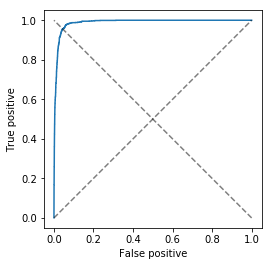

In [16]:
test_roc(graph, data_train, model="purpose")

# Eval validation

INFO:tensorflow:Restoring parameters from model_dash/model.chkpt
AUC: 0.847367021277


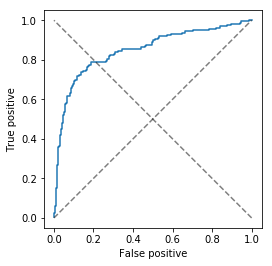

In [17]:
test_roc(graph, data_valid, model="purpose")

## Eval test

INFO:tensorflow:Restoring parameters from model_dash/model.chkpt
AUC: 0.852241870323


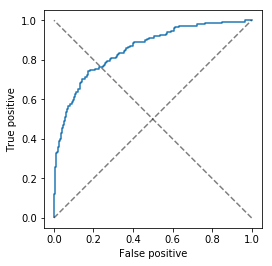

In [18]:
test_roc(graph, data_test, model="purpose")